In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
import time
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import time
%matplotlib inline

## Helper Functions

In [3]:
def imshow(img, size=None):
    if size == None:
        plt.figure(figsize=(14,18))
    else:
        plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def imshow2(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def backgroundExtract(frames):
    avgR, avgG, avgB = None, None, None
    fcnt = 0
    for frame in frames:
        if frame is None:
            break
        frame = cv2.imread(frame)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        B, G, R = cv2.split(frame.astype("float"))
        if avgR is None:
            avgR = R
            avgG = G
            avgB = B
        else:
            avgB = avgB + 1/fcnt*(B - avgB)
            avgG = avgG + 1/fcnt*(G - avgG)
            avgR = avgR + 1/fcnt*(R - avgR)
        
        fcnt += 1

        avg = cv2.merge([avgB, avgG, avgR]).astype('uint8')
        #avg = cv2.cvtColor(avg, cv2.COLOR_HSV2BGR)

    return avg

def robotSegment(img, bg, th):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype('float32')
    bg_gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY).astype('float32')

    #img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #bg_hsv = cv2.cvtColor(bg, cv2.COLOR_BGR2HSV)

    thresh = th

    sub = np.abs(img_gray - bg_gray)
    sub = (sub>thresh)*255
    sub = sub.astype('uint8')

    kernel1 = np.ones((2, 2), np.uint8)
    kernel2 = np.ones((3, 3), np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    #erosion = cv2.erode(sub,kernel,iterations = 1)

    # Openning operation to remove noise
    res = cv2.morphologyEx(sub, cv2.MORPH_OPEN, kernel1)
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel2)

    return res


def robotSegmentv2(img, bg):

    # Color Threshold
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([45, 70, 70])
    upper_bound = np.array([75, 255, 255])

    mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
    mask_inv = cv2.bitwise_not(mask)

    img_mask = cv2.bitwise_and(img, img, mask=mask_inv)
    bg_mask = cv2.bitwise_and(bg, bg, mask=mask_inv)

    img_gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY).astype('float32')
    bg_gray = cv2.cvtColor(bg_mask, cv2.COLOR_BGR2GRAY).astype('float32')

    img_gray = cv2.GaussianBlur(img_gray,(5,5),0)
    bg_gray = cv2.GaussianBlur(bg_gray,(5,5),0)

    thresh = 25
    
    #img1 = img_mask.astype('float32')
    #bg1 = bg_mask.astype('float32')
    
    #img1 = cv2.GaussianBlur(img1,(5,5),0)
    #bg1 = cv2.GaussianBlur(bg1,(5,5),0)
    
    sub = np.abs(img_gray - bg_gray)
    #sub1 = np.abs(img1[:,:,0] - bg1[:,:,0])
    #sub2 = np.abs(img1[:,:,1] - bg1[:,:,1])
    #sub3 = np.abs(img1[:,:,2] - bg1[:,:,2])
    #sub = (sub1+sub2+sub3)/3
    sub = (sub>thresh)*255
    sub = sub.astype('uint8')

    kernel1 = np.ones((2, 2), np.uint8)
    kernel2 = np.ones((3, 3), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    #erosion = cv2.erode(sub,kernel,iterations = 1)

    # Openning operation to remove noise
    e = cv2.morphologyEx(sub, cv2.MORPH_ERODE, kernel1)
    res = cv2.morphologyEx(e, cv2.MORPH_DILATE, kernel2)

    return res

def downsample(img, sample_interval = 10):

    x, y = np.where(img == 255)
    data = []
    for x_loc, y_loc in zip(x, y):
        data.append([x_loc, y_loc])

    sample_interval = sample_interval
    sample_bnd = np.floor(len(data)/sample_interval).astype('int')
    sample_idx = [i*sample_interval for i in range(0, sample_bnd)]
    sample_data = [data[i] for i in sample_idx]

    sample_img = np.zeros(img.shape[:2]).astype('int')
    for x, y in sample_data:
        sample_img[x][y] = 255

    return img

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imshow('labeled.png', labeled_img)
    cv2.waitKey()

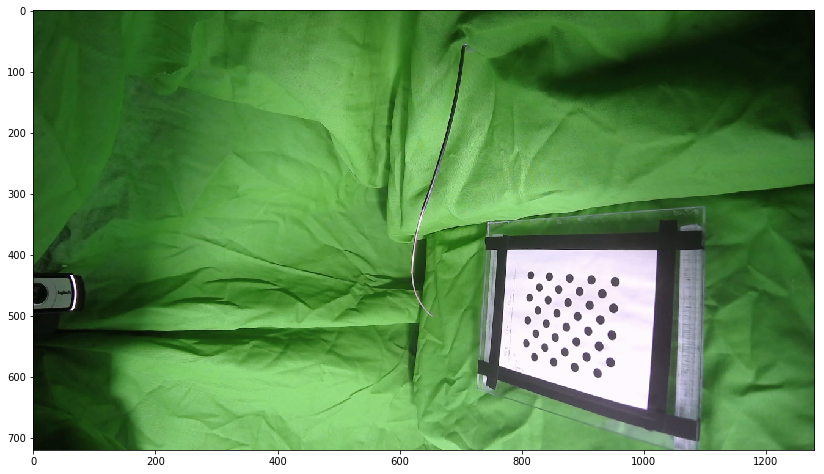

In [4]:
img = cv2.imread('../../data/CTR_Robot/Camera1/cam1_73.png')
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
imshow(img)

## Threshold Green Background

[[[ 60 255 255]]]


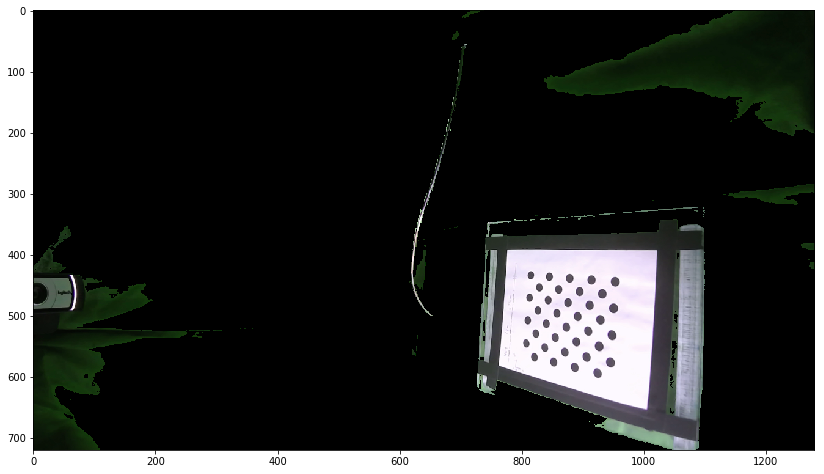

In [5]:
# Locate green color in HSV space
green = np.uint8([[[0,255,0]]])
green_hsv = cv2.cvtColor(green, cv2.COLOR_BGR2HSV)
print(green_hsv)

# Setting boundary in HSV space
lower_bound = np.array([45, 70, 60])
upper_bound = np.array([75, 255, 255])

mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
mask_inv = cv2.bitwise_not(mask)
res = cv2.bitwise_and(img, img, mask=mask_inv)
imshow(res)

## Edge Detection

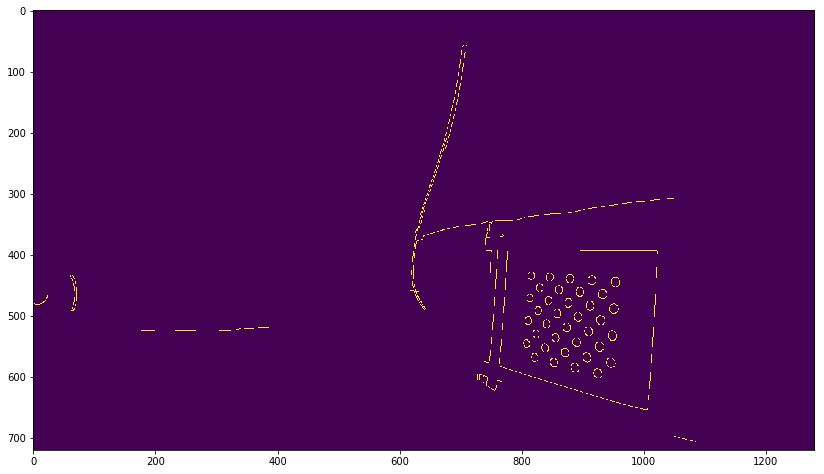

In [6]:
max_lowThreshold = 100
ratio = 3
kernel_size = 3

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.blur(img_gray, (2,2))
edges = cv2.Canny(img_blur, 200, 500)

imshow(edges)

## Background Removal (GM)

In [5]:
images = glob.glob('../data/CTR_Robot/Camera1/*.png')

backSub = cv2.createBackgroundSubtractorMOG2(history=100)

images = glob.glob('../data/CTR_Robot/Camera1/*.png')
for frame in images:
    if frame is None:
        break
    frame = cv2.imread(frame)

    fgMask = backSub.apply(frame)

    cv2.imshow('Frame', frame)
    cv2.imshow('FG Mask', fgMask)

    keyboard = cv2.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

## Obtain Background (view 1)

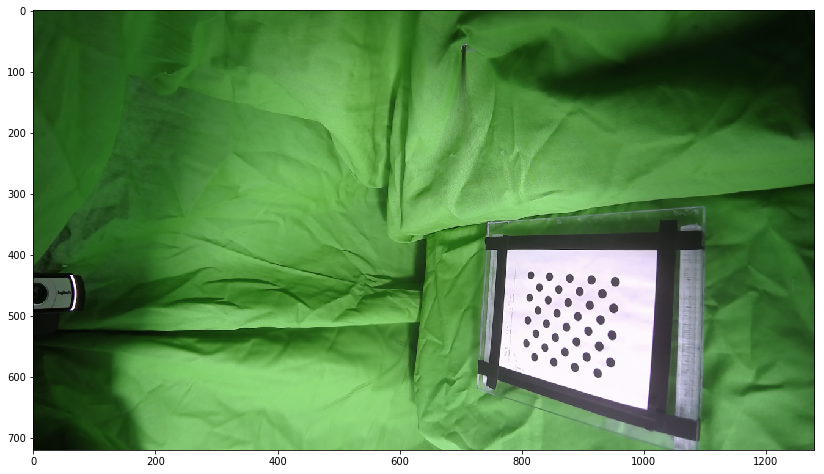

In [2]:
images = glob.glob('./bg_cam1/*.png')
bg1 = backgroundExtract(images)
imshow(bg1)
#cv2.imwrite('bg_1.png', avg)

## Obtain Background (view 2)

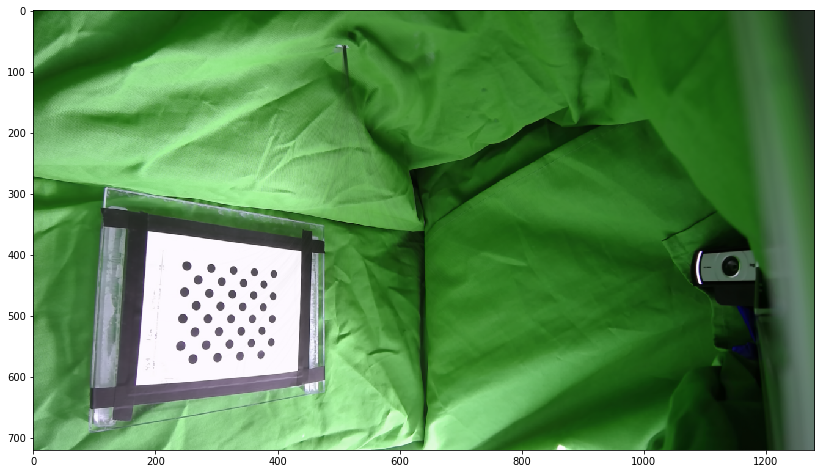

True

In [37]:
images = glob.glob('./bg_cam2/*.png')
bg2 = backgroundExtract(images)
imshow(bg2)
cv2.imwrite('bg_2_t.png', bg2)

## Robot Body Segment (view 1)

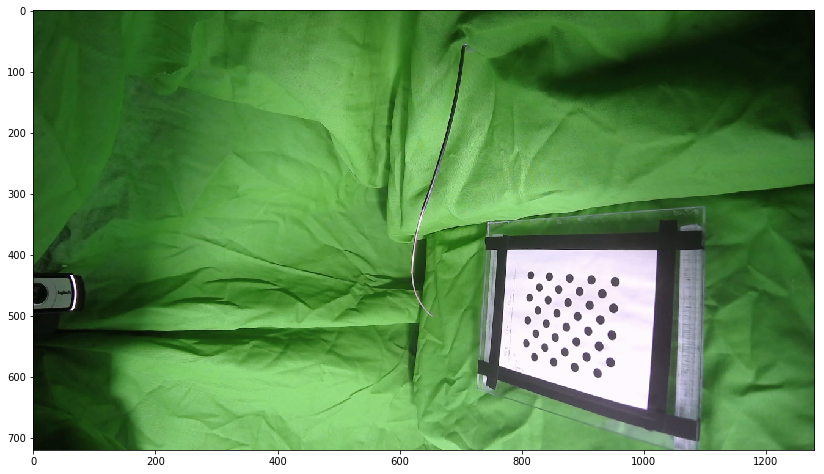

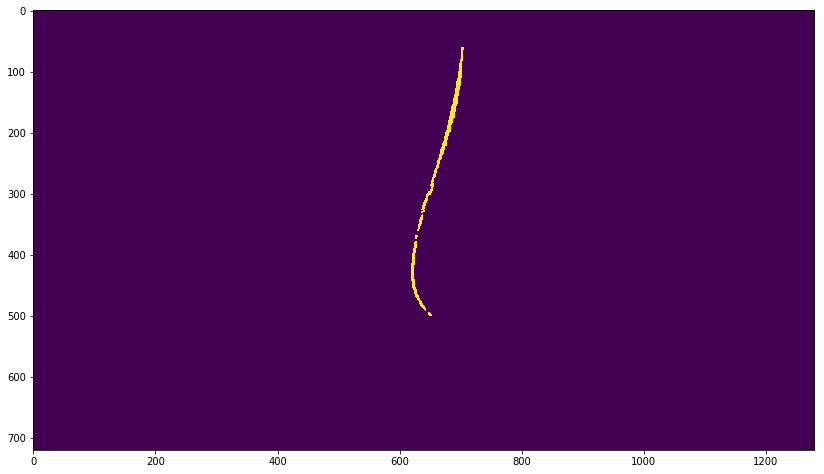

In [7]:
img = cv2.imread('../../data/CTR_Robot/Camera1/cam1_73.png')
bg = cv2.imread('./bg_res/bg_1.png')
res1 = robotSegmentv2(img, bg)
imshow(img)
imshow(res1)

## Robot Body Segment (view 2)

0.02429509162902832


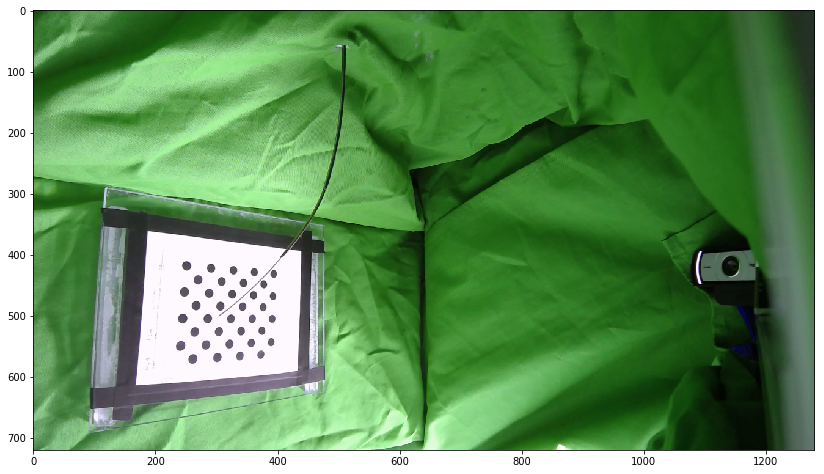

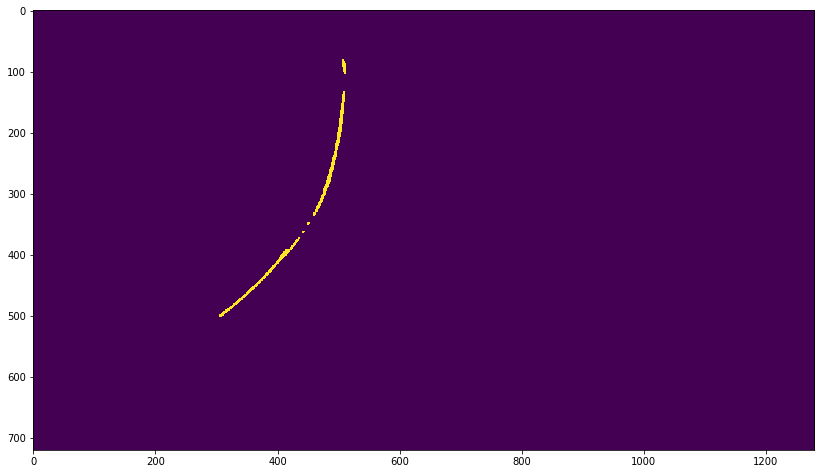

In [8]:
img = cv2.imread('../../data/CTR_Robot/Camera2/cam2_73.png')
bg = cv2.imread('./bg_res/bg_2_1.png')
#res2 = robotSegment(img, bg, 40)
start = time.time()
res2 = robotSegmentv2(img, bg)
print(time.time() - start)
imshow(img)
imshow(res2)

## RANSAC Curve Fitting (view 1)

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


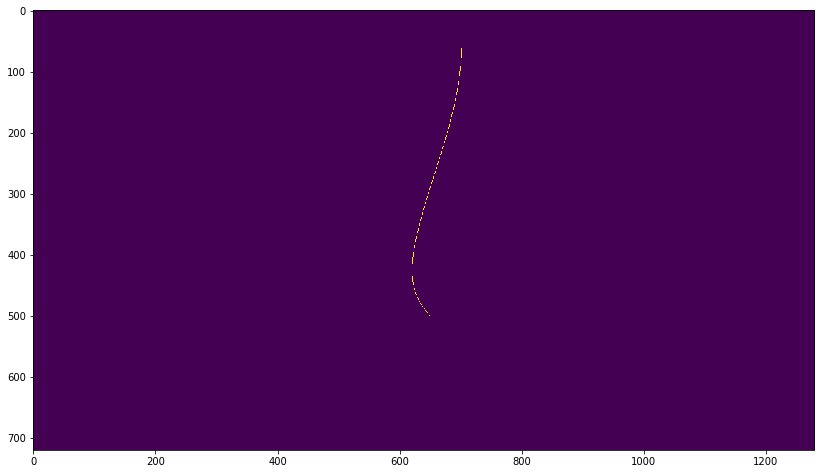

In [9]:
# Find all the data points in mask
data = np.where(res1==255)
X,y = data[0], data[1]
X = X.reshape(-1,1)

# Create poly feature to fit
poly = PolynomialFeatures(degree = 7, include_bias = True)
X = poly.fit_transform(X)

# Create RANSAC model
ransac = RANSACRegressor(min_samples=0.3, max_trials=100)
ransac.fit(X,y)

# Prepare to plot the curve
#low = min(X[:,1])
low = 55
upper = max(X[:,1])
#upper = 650
point_num = upper - low + 1

x_plot = np.linspace(low, upper, point_num).astype('int')
x_plot_t = poly.fit_transform(x_plot.reshape(-1,1))
y_plot = ransac.predict(x_plot_t).astype('int')

curve_fit = np.zeros(res1.shape)
for x, y in zip(x_plot, y_plot):
    if x < upper:
        curve_fit[x,y] = 255

imshow(curve_fit)
#cv2.imwrite('seg140_l.png', curve_fit)

## RANSAC Curve Fitting (view 2)

0.006979942321777344


D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


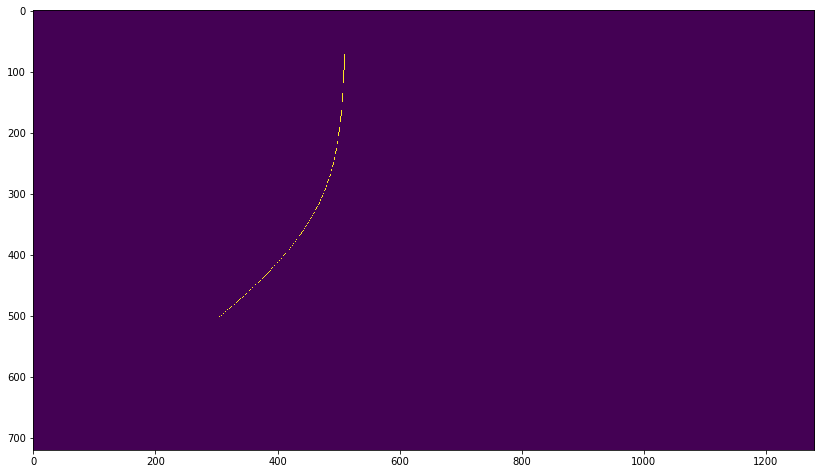

In [10]:
start = time.time()
# Find all the data points in mask
data = np.where(res2==255)
X,y = data[0], data[1]
X = X.reshape(-1,1)

# Create poly feature to fit
poly = PolynomialFeatures(degree = 7, include_bias = True)
X = poly.fit_transform(X)

# Create RANSAC model
ransac = RANSACRegressor(min_samples=0.3, max_trials=100)
ransac.fit(X,y)

print(time.time() - start)

# Prepare to plot the curve
#low = min(X[:,1])
low = 55
upper = max(X[:,1])
#upper = 412
point_num = upper - low + 1


x_plot = np.linspace(low, upper, point_num).astype('int')
x_plot_t = poly.fit_transform(x_plot.reshape(-1,1))
y_plot = ransac.predict(x_plot_t).astype('int')

curve_fit = np.zeros(res2.shape)
for x, y in zip(x_plot, y_plot):
    if x < upper:
        curve_fit[x,y] = 255

imshow(curve_fit)
#cv2.imwrite('seg140_r.png', curve_fit)

## Meeting
1. Improve line fitting algorithm. Even order for single maximum, odds order for multiple maximums (Poly fitting algorithm) Odds recommeded
2. Line tracking. If we can connected the line pieces in the subtraction results.
3. Camera calibration. Calibrate without incorrectly matched dots. (Ignore them)

## Segmentation Test Platform

In [89]:
#transverse all the frames selected

images = glob.glob('../../data/CTR_Robot/Camera2/*.png')
bg = cv2.imread('bg_2.png')
for fnm in images:
    img = cv2.imread(fnm)
    res = robotSegmentv2(img, bg)
    cv2.imshow('img', img)
    cv2.imshow('seg', res)
    cv2.waitKey(50)
    
cv2.destroyAllWindows()

In [36]:
idx =1
imgs = []
interval = 50
start = list(np.linspace(0, 800, num = 17).astype(int))

for i, ele in enumerate(start[:-1]):
    idx_list = np.linspace(ele, ele+interval, num = interval).astype('int')
    imgs.append([])
    for idx in idx_list:
        imgs[i].append('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')

In [4]:
index = 0
for img_group in imgs:
    bg2 = backgroundExtract(img_group)
    cv2.imwrite('bg_2_' + str(index) + '.png', bg2)
    index += 1

In [131]:
imgs = []
ele = 650
idx_list = np.linspace(ele, ele+interval, num = interval).astype('int')
for idx in idx_list:
    if idx not in range(650, 655):
        if idx not in range(678, 699):
            imgs.append('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')

In [133]:
index = 13
bg2 = backgroundExtract(imgs)
cv2.imwrite('bg_2_' + str(index) + '.png', bg2)

True

## Curve Fit Test

In [230]:
def ransacCurveFit(seg_img, degree = 7, trials = 100, sampleNum = 100):
# Find all the data points in mask
    data = np.where(seg_img==255)
    X,y = data[0], data[1]
    X = X.reshape(-1,1)

    # Create poly feature to fit
    poly = PolynomialFeatures(degree = degree, include_bias = True)
    X = poly.fit_transform(X)

    # Create RANSAC model
    ransac = RANSACRegressor(min_samples=0.3, max_trials=trials)
    ransac.fit(X,y)

    # Prepare to plot the curve
    low = 55
    upper = max(X[:,1])

    point_num = sampleNum


    x_sample = np.linspace(low, upper, point_num)
    x_sample_trans = poly.fit_transform(x_sample.reshape(-1,1))
    y_sample = ransac.predict(x_sample_trans)
    
    pts = np.vstack((y_sample, x_sample))
    return pts

## Pair selection

In [24]:
cv2.namedWindow('img')
cv2.namedWindow('seg')
valid_pair = []
# Robot images
idx_all = list(range(300, 500))
#idx = 300
for idx in idx_all:
    imgL = cv2.imread('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
    imgR = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

    bg1 = cv2.imread('./bg_res/bg_1.png')
    bg2 = cv2.imread('./bg_res/bg_2_' + str(idx//50) + '.png')

    segL = robotSegmentv2(imgL, bg2)
    segR = robotSegmentv2(imgR, bg1)

    fitL = ransacCurveFit(segL)
    fitR = ransacCurveFit(segR)
    
    
    conImg = np.hstack((imgL, imgR))
    conSeg = np.hstack((fitL, fitR))
    
    
    conImg = cv2.resize(conImg, (1280, 360), interpolation = cv2.INTER_CUBIC)
    conSeg = cv2.resize(conSeg, (1280, 360), interpolation = cv2.INTER_CUBIC)
    
    while True:
        cv2.imshow('img', conImg)
        cv2.imshow('seg', conSeg)
        k = cv2.waitKey(20) & 0xFF
        if k == 27:
            break
        elif k == ord('a'):
            valid_pair.append(idx)
            break
            
cv2.destroyAllWindows()

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Anaconda\envs\stereo\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely i

In [5]:
def ransacCurveFit(seg_img, degree = 7, trials = 100):
    data = np.where(seg_img==255)
    X,y = data[0], data[1]
    X = X.reshape(-1,1)

    # Create poly feature to fit
    poly = PolynomialFeatures(degree = degree, include_bias = True)
    X = poly.fit_transform(X)

    # Create RANSAC model
    ransac = RANSACRegressor(min_samples=0.3, max_trials=trials, random_state= 0)
    ransac.fit(X,y)

    # Prepare to plot the curve
    #low = min(X[:,1])
    low = 55
    upper = max(X[:,1])
    point_num = upper - low + 1

    x_plot = np.linspace(low, upper, point_num).astype('int')
    x_plot_t = poly.fit_transform(x_plot.reshape(-1,1))
    y_plot = ransac.predict(x_plot_t).astype('int')

    curve_fit = np.zeros(seg_img.shape)
    for x, y in zip(x_plot, y_plot):
        if x < upper:
            curve_fit[x,y] = 255

    return curve_fit

In [27]:
#np.save('evaluation_idx.npy', valid_pair)

In [3]:
indices = np.load('evaluation_idx.npy')

In [28]:
# Label robot joints
class ptCoord:
    def __init__(self):
        self.points = []

    def click_and_mark(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points.append((x,y))
    
    def reset(self):
        self.points = []
                
ptl = ptCoord()
pt_right = {}

for idx in indices:
    img_right = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')
    
    cv2.namedWindow('imgLeft')
    cv2.setMouseCallback('imgLeft', ptl.click_and_mark)
    cv2.imshow('imgLeft',img_right)
    
    k = cv2.waitKey(0) & 0xFF
    if k == ord('a'):
        pt_right[idx] = ptl.points
        ptl.reset()
    cv2.destroyAllWindows()  

In [25]:
pt_left_real = {}
for key in pt_left.keys():
    if len(pt_left[key]) == 2:
        pt_left_real[key] = pt_left[key]

In [27]:
#np.save('evaluation_pt_left.npy', pt_left_real)

In [ ]:
pt_right_real = {}
for key in pt_right.keys():
    if len(pt_right[key]) == 2:
        pt_right_real[key] = pt_right[key]

In [33]:
right_comp = {}
for key in pt_right_real.keys():
    if key not in pt_left_real:
        right_comp[key] = pt_right_real[key]

In [35]:
#np.save('evaluation_pt_right_comp.npy', right_comp)